In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\johbr\AppData\Local\Temp\ipykernel_2388\138741423.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [4]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [5]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]

In [7]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False


In [8]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
# scaled_df = pd.DataFrame(X_scaled, columns=dummies.drop(columns="SalePrice").columns)

In [9]:
# plot data before scaling
# dummies.plot(title='Before Scaling', figsize=(10, 6))
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.show()

# # after scaling
# scaled_df.plot(title='After Scaling', figsize=(10, 6))
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.show()

## Compile, Train, Evaluate the Model

In [10]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=50, max_value=600, step=50),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [11]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 23s]
mae: 2514.673095703125

Best mae So Far: 2514.673095703125
Total elapsed time: 00h 03m 54s


In [12]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 09 summary
Hyperparameters:
num_layers: 5
layer0: 50
activation0: tanh
layer1: 550
activation1: relu
layer2: 450
activation2: tanh
layer3: 50
activation3: LeakyReLU
layer4: 300
activation4: relu
Score: 2514.673095703125

Trial 01 summary
Hyperparameters:
num_layers: 5
layer0: 200
activation0: tanh
layer1: 600
activation1: relu
layer2: 100
activation2: LeakyReLU
layer3: 50
activation3: relu
layer4: 50
activation4: relu
Score: 3496.22900390625

Trial 03 summary
Hyperparameters:
num_layers: 4
layer0: 100
activation0: relu
layer1: 500
activation1: LeakyReLU
layer2: 200
activation2: relu
layer3: 200
activation3: relu
layer4: 350
activation4: relu
Score: 3643.494140625

Trial 08 summary
Hyperparameters:
num_layers: 5
layer0: 450
activation0: tanh
layer1: 200
activation1: tanh
layer2: 350
activation2: LeakyReLU
layer3: 550
activation3: tanh
layer4: 600
activation4: LeakyReLU
Scor

In [13]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/100
35/35 [==============================] - 2s 11ms/step - loss: 182212.1719 - mae: 182212.1719 - val_loss: 174002.1094 - val_mae: 174002.1094
Epoch 2/100
35/35 [==============================] - 0s 5ms/step - loss: 180960.7969 - mae: 180960.7969 - val_loss: 171343.5156 - val_mae: 171343.5156
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 175925.3594 - mae: 175925.3594 - val_loss: 162908.6719 - val_mae: 162908.6719
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 163020.0156 - mae: 163020.0156 - val_loss: 144168.3594 - val_mae: 144168.3594
Epoch 5/100
35/35 [==============================] - 0s 7ms/step - loss: 137615.1875 - mae: 137615.1875 - val_loss: 110765.5859 - val_mae: 110765.5859
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 97018.6328 - mae: 97018.6328 - val_loss: 66476.5234 - val_mae: 66476.5234
Epoch 7/100
35/35 [==============================] - 0s 5ms/step - loss: 60958.1914 - mae: 60958.

In [24]:
print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters:
{'num_layers': 5, 'layer0': 50, 'activation0': 'tanh', 'layer1': 550, 'activation1': 'relu', 'layer2': 450, 'activation2': 'tanh', 'layer3': 50, 'activation3': 'LeakyReLU', 'layer4': 300, 'activation4': 'relu'}


In [14]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                14350     
                                                                 
 dense_7 (Dense)             (None, 550)               28050     
                                                                 
 dense_8 (Dense)             (None, 450)               247950    
                                                                 
 dense_9 (Dense)             (None, 50)                22550     
                                                                 
 dense_10 (Dense)            (None, 300)               15300     
                                                                 
 dense_11 (Dense)            (None, 1)                 301       
                                                                 
Total params: 328501 (1.25 MB)
Trainable params: 32850

In [15]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[-0.2095117   0.00327939  0.05647943 ... -0.09683399 -0.04313637
  -0.06969768]
 [-0.00303014  0.1655164  -0.00236282 ... -0.0031082   0.02422269
  -0.09459799]
 [ 0.24373199  0.22561729  0.20379505 ...  0.3198084  -0.25426102
  -0.10657255]
 ...
 [ 0.01594414 -0.00819941  0.23049967 ... -0.00508133 -0.1334427
   0.14902496]
 [ 0.15221037  0.00412728 -0.00893348 ...  0.01052969 -0.04568504
   0.09568491]
 [ 0.03422497 -0.04474776  0.139524   ...  0.02472075 -0.05758678
  -0.23304175]]
Layer 1 Weights:
[-0.19261509 -0.02181458 -0.19113688  0.03044098  0.07606156 -0.00154698
  0.00748018 -0.00581202  0.11983948 -0.20787153 -0.19321652  0.09528021
  0.03965966  0.00133628  0.16528186  0.06236057 -0.18827927  0.03293606
  0.07411075 -0.04767322 -0.16510236  0.14229208 -0.00756679  0.03028408
  0.0952941  -0.24834545  0.06172966  0.16855584 -0.1663089  -0.20986767
 -0.00174228  0.01793228  0.02457235  0.00884682 -0.04744579  0.07093114
 -0.14907728 -0.14806403 -0.28660598 

In [16]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

6/6 [==============================] - 0s 2ms/step


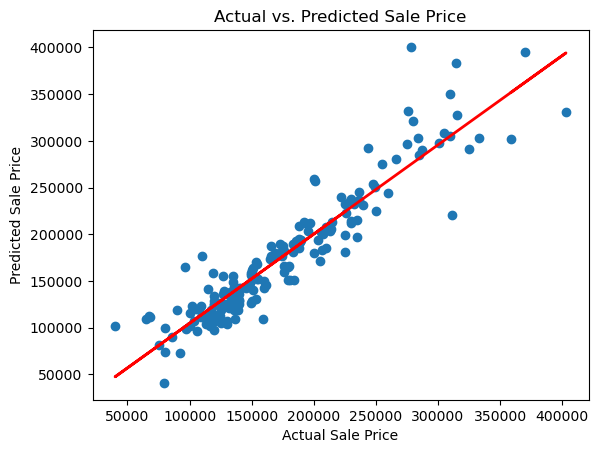

In [17]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [18]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: 0.858738607936076
Mean Squared Error: 613235770.6183003
Mean Absolute Error: 16872.33552970467
Mean Percentage Error: -16.38835894709905


In [19]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -0.020610114208674313
Baseline Mean Squared Error: 4430613494.197803
Baseline Mean Absolute Error: 54345.8021978022
Mean Percentage Error: -21.726878869297774


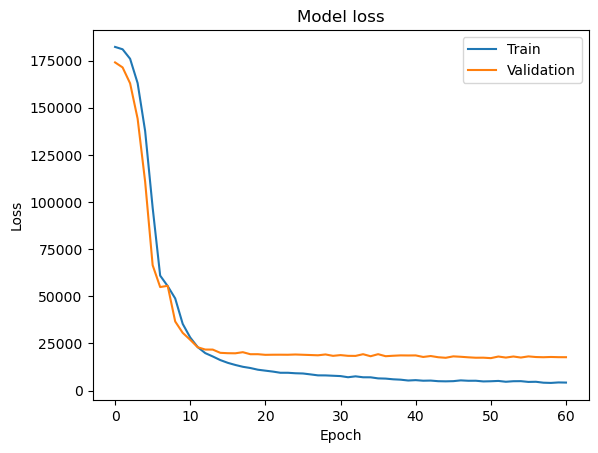

In [20]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

6/6 [==============================] - 0s 2ms/step


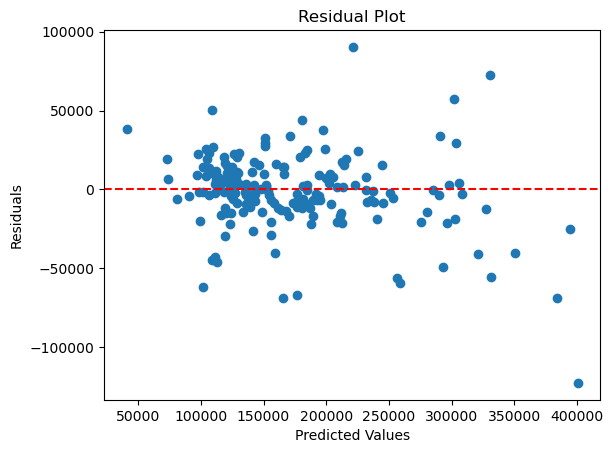

In [21]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

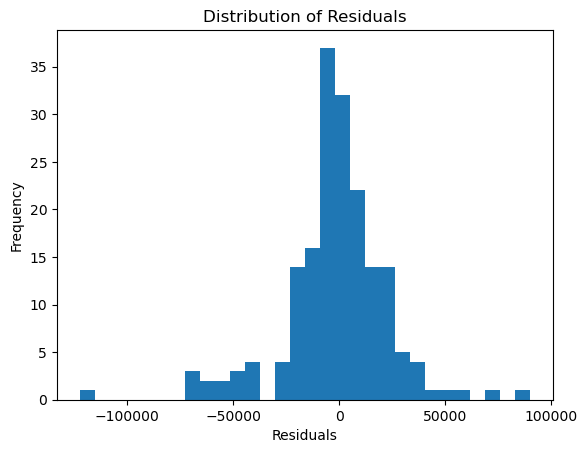

In [22]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [23]:
# plot the learning curve?